# Visualize Amazon Customer Reviews Dataset
For this notebook, we will query a subset of reviews for the Digital Software, Digital Video Games, and Gift Card product categories.  We will also show the results for the entire dataset.

# Dataset Column Descriptions

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.
- `year`: The year derived from the review date.

In [1]:
import sagemaker
import boto3

sess = sagemaker.Session()
print('sess :{}'.format(sess))
bucket = sess.default_bucket()
print('bucket :{}'.format(bucket))
role = sagemaker.get_execution_role()
print('role : {}'.format(role))
region = boto3.Session().region_name
print('region : {}'.format(region))
account_id = boto3.client("sts").get_caller_identity().get("Account")
print('account_id : {}'.format(account_id))

sess :<sagemaker.session.Session object at 0x7f5bd62dda90>
bucket :sagemaker-ap-northeast-2-870327349328
role : arn:aws:iam::870327349328:role/service-role/AmazonSageMaker-ExecutionRole-20210511T115517
region : ap-northeast-2
account_id : 870327349328


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
%store -r ingest_create_athena_table_parquet_passed
ingest_create_athena_table_parquet_passed

True

In [6]:
try:
    ingest_create_athena_table_parquet_passed
except NameError:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL PREVIOUS NOTEBOOKS")
    print("You did not convert into Parquet data.        ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")

In [7]:
print(ingest_create_athena_table_parquet_passed)

True


In [8]:
if not ingest_create_athena_table_parquet_passed:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL PREVIOUS NOTEBOOKS")
    print("You did not convert into Parquet data.        ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")
else:
    print("[OK]")

[OK]


In [9]:
database_name = "default"
table_name = "amazon_reviews_parquet"

In [11]:
!pip install pyathena
from pyathena import connect

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached tenacity-7.0.0-py2.py3-none-any.whl (23 kB)


In [12]:
s3_staging_dir = "s3://{}/athena/query-cache".format(bucket)

In [24]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

# Set Seaborn Parameters

In [14]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Helper Code to Display Values on Bars

In [15]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# 1. Which Product Categories are Highest Rated by Average Rating?

In [16]:
%%time

# SQL statement
statement = """
    SELECT product_category, AVG(star_rating) AS avg_star_rating
    FROM {}.{} 
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY product_category 
    ORDER BY avg_star_rating DESC
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df.head(5)


    SELECT product_category, AVG(star_rating) AS avg_star_rating
    FROM default.amazon_reviews_parquet 
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY product_category 
    ORDER BY avg_star_rating DESC

CPU times: user 117 ms, sys: 11.6 ms, total: 129 ms
Wall time: 7.57 s


,product_category,avg_star_rating
0,Gift_Card,4.731363
1,Digital_Video_Games,3.853126
2,Digital_Software,3.539330


In [32]:
# see database name
cursor = conn.cursor()
statement = 'SHOW DATABASES'
print(statement)
cursor.execute(statement)
databases = cursor.fetchall()
print('databases')
for db in databases:
    print(db)
    # see table name
    cursor.execute('SHOW TABLES')
    tables = cursor.fetchall()
    print('tables')
    for tb in tables:
        print(tb)
        statement = """
            SELECT column_name
            FROM information_schema.columns
            WHERE table_name='{}'
        """.format(tb[0])
        print(statement)
        cursor.execute(statement)
        columns = cursor.fetchall()
        for cl in columns:
            print(cl)


SHOW DATABASES
databases
('default',)
tables
('amazon_reviews_parquet',)

            SELECT column_name
            FROM information_schema.columns
            WHERE table_name='amazon_reviews_parquet'
        
('marketplace',)
('customer_id',)
('review_id',)
('product_id',)
('product_parent',)
('product_title',)
('star_rating',)
('helpful_votes',)
('total_votes',)
('vine',)
('verified_purchase',)
('review_headline',)
('review_body',)
('review_date',)
('year',)
('product_category',)


In [27]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

# Store average star ratings
average_star_ratings = df

3


## Visualization for a Subset of Product Categories

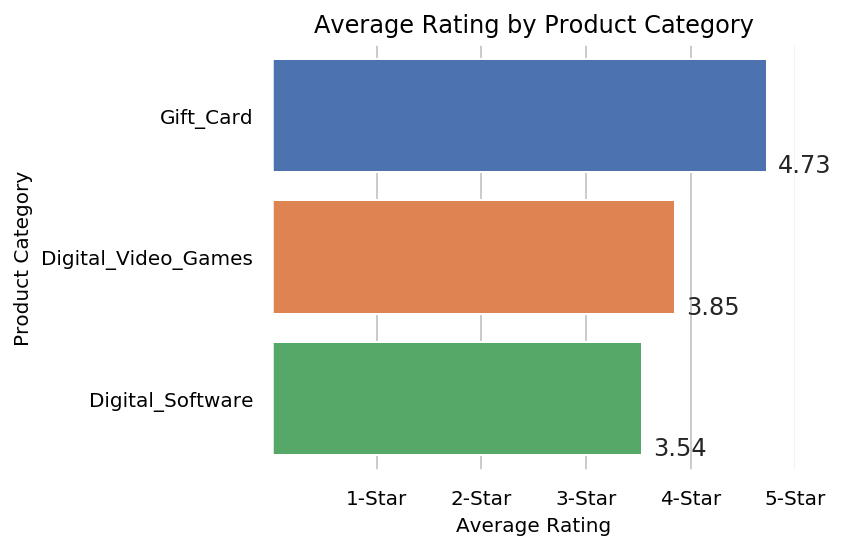

In [33]:
# Create plot
barplot = sns.barplot(y="product_category", x="avg_star_rating", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title and x-axis ticks
plt.title("Average Rating by Product Category")
plt.xticks([1, 2, 3, 4, 5], ["1-Star", "2-Star", "3-Star", "4-Star", "5-Star"])

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c5-01.png"  width="80%" align="left">

# 2. Which Product Categories Have the Most Reviews?

In [34]:
# SQL statement
statement = """
    SELECT product_category, COUNT(star_rating) AS count_star_rating 
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category 
    ORDER BY count_star_rating DESC
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df.head()


    SELECT product_category, COUNT(star_rating) AS count_star_rating 
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category 
    ORDER BY count_star_rating DESC



,product_category,count_star_rating
0,Gift_Card,149086
1,Digital_Video_Games,145431
2,Digital_Software,102084


In [35]:
# Store counts
count_ratings = df["count_star_rating"]

# Store max ratings
max_ratings = df["count_star_rating"].max()
print(max_ratings)

149086


## Visualization for a Subset of Product Categories

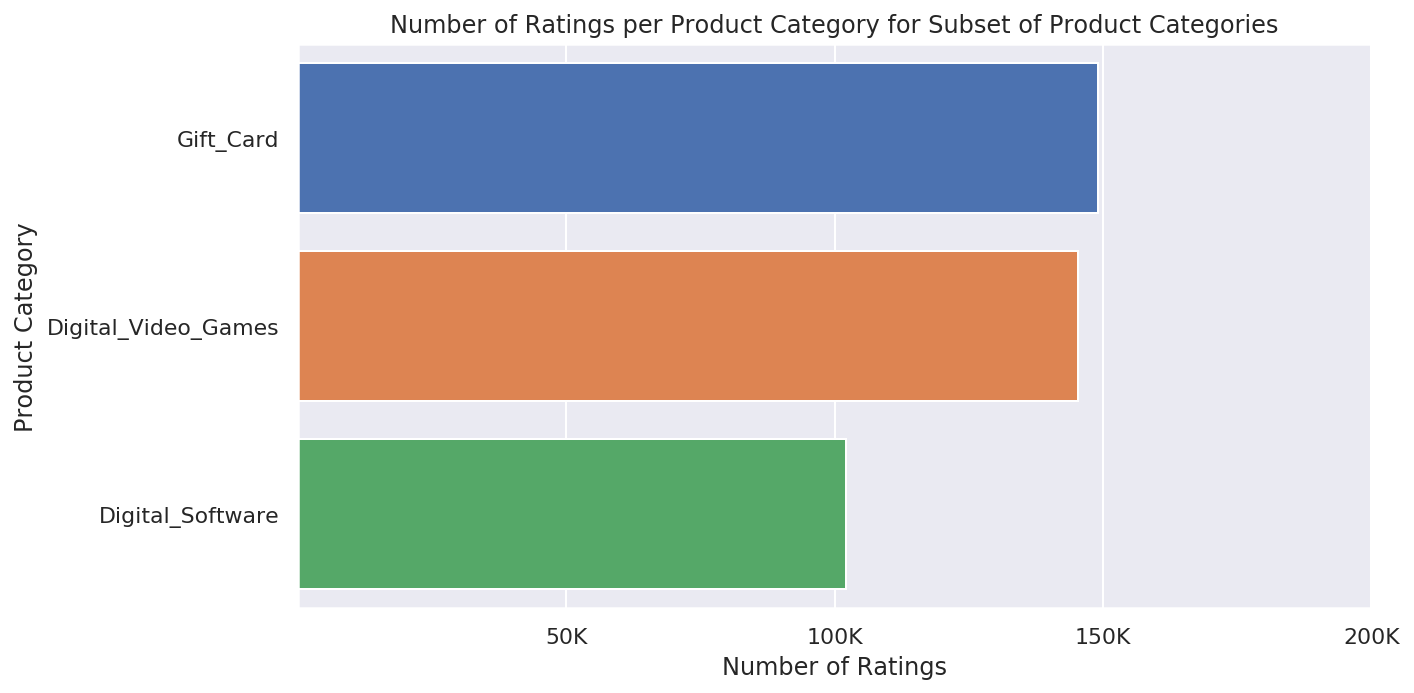

In [36]:
# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "150K", "200K"])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c5-02.png"  width="80%" align="left">

In [37]:
# SQL statement
statement = """
    SELECT product_category, COUNT(star_rating) AS count_star_rating 
    FROM {}.{}
    GROUP BY product_category 
    ORDER BY count_star_rating DESC
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df.head()


    SELECT product_category, COUNT(star_rating) AS count_star_rating 
    FROM default.amazon_reviews_parquet
    GROUP BY product_category 
    ORDER BY count_star_rating DESC



,product_category,count_star_rating
0,Books,20726160
1,Digital_Ebook_Purchase,19180765
2,Wireless,9038249
3,Video_DVD,7135819
4,PC,7004337


In [39]:
# Store counts
count_ratings = df["count_star_rating"]

# Store max ratings
max_ratings = df["count_star_rating"].max()
print(max_ratings)

20726160


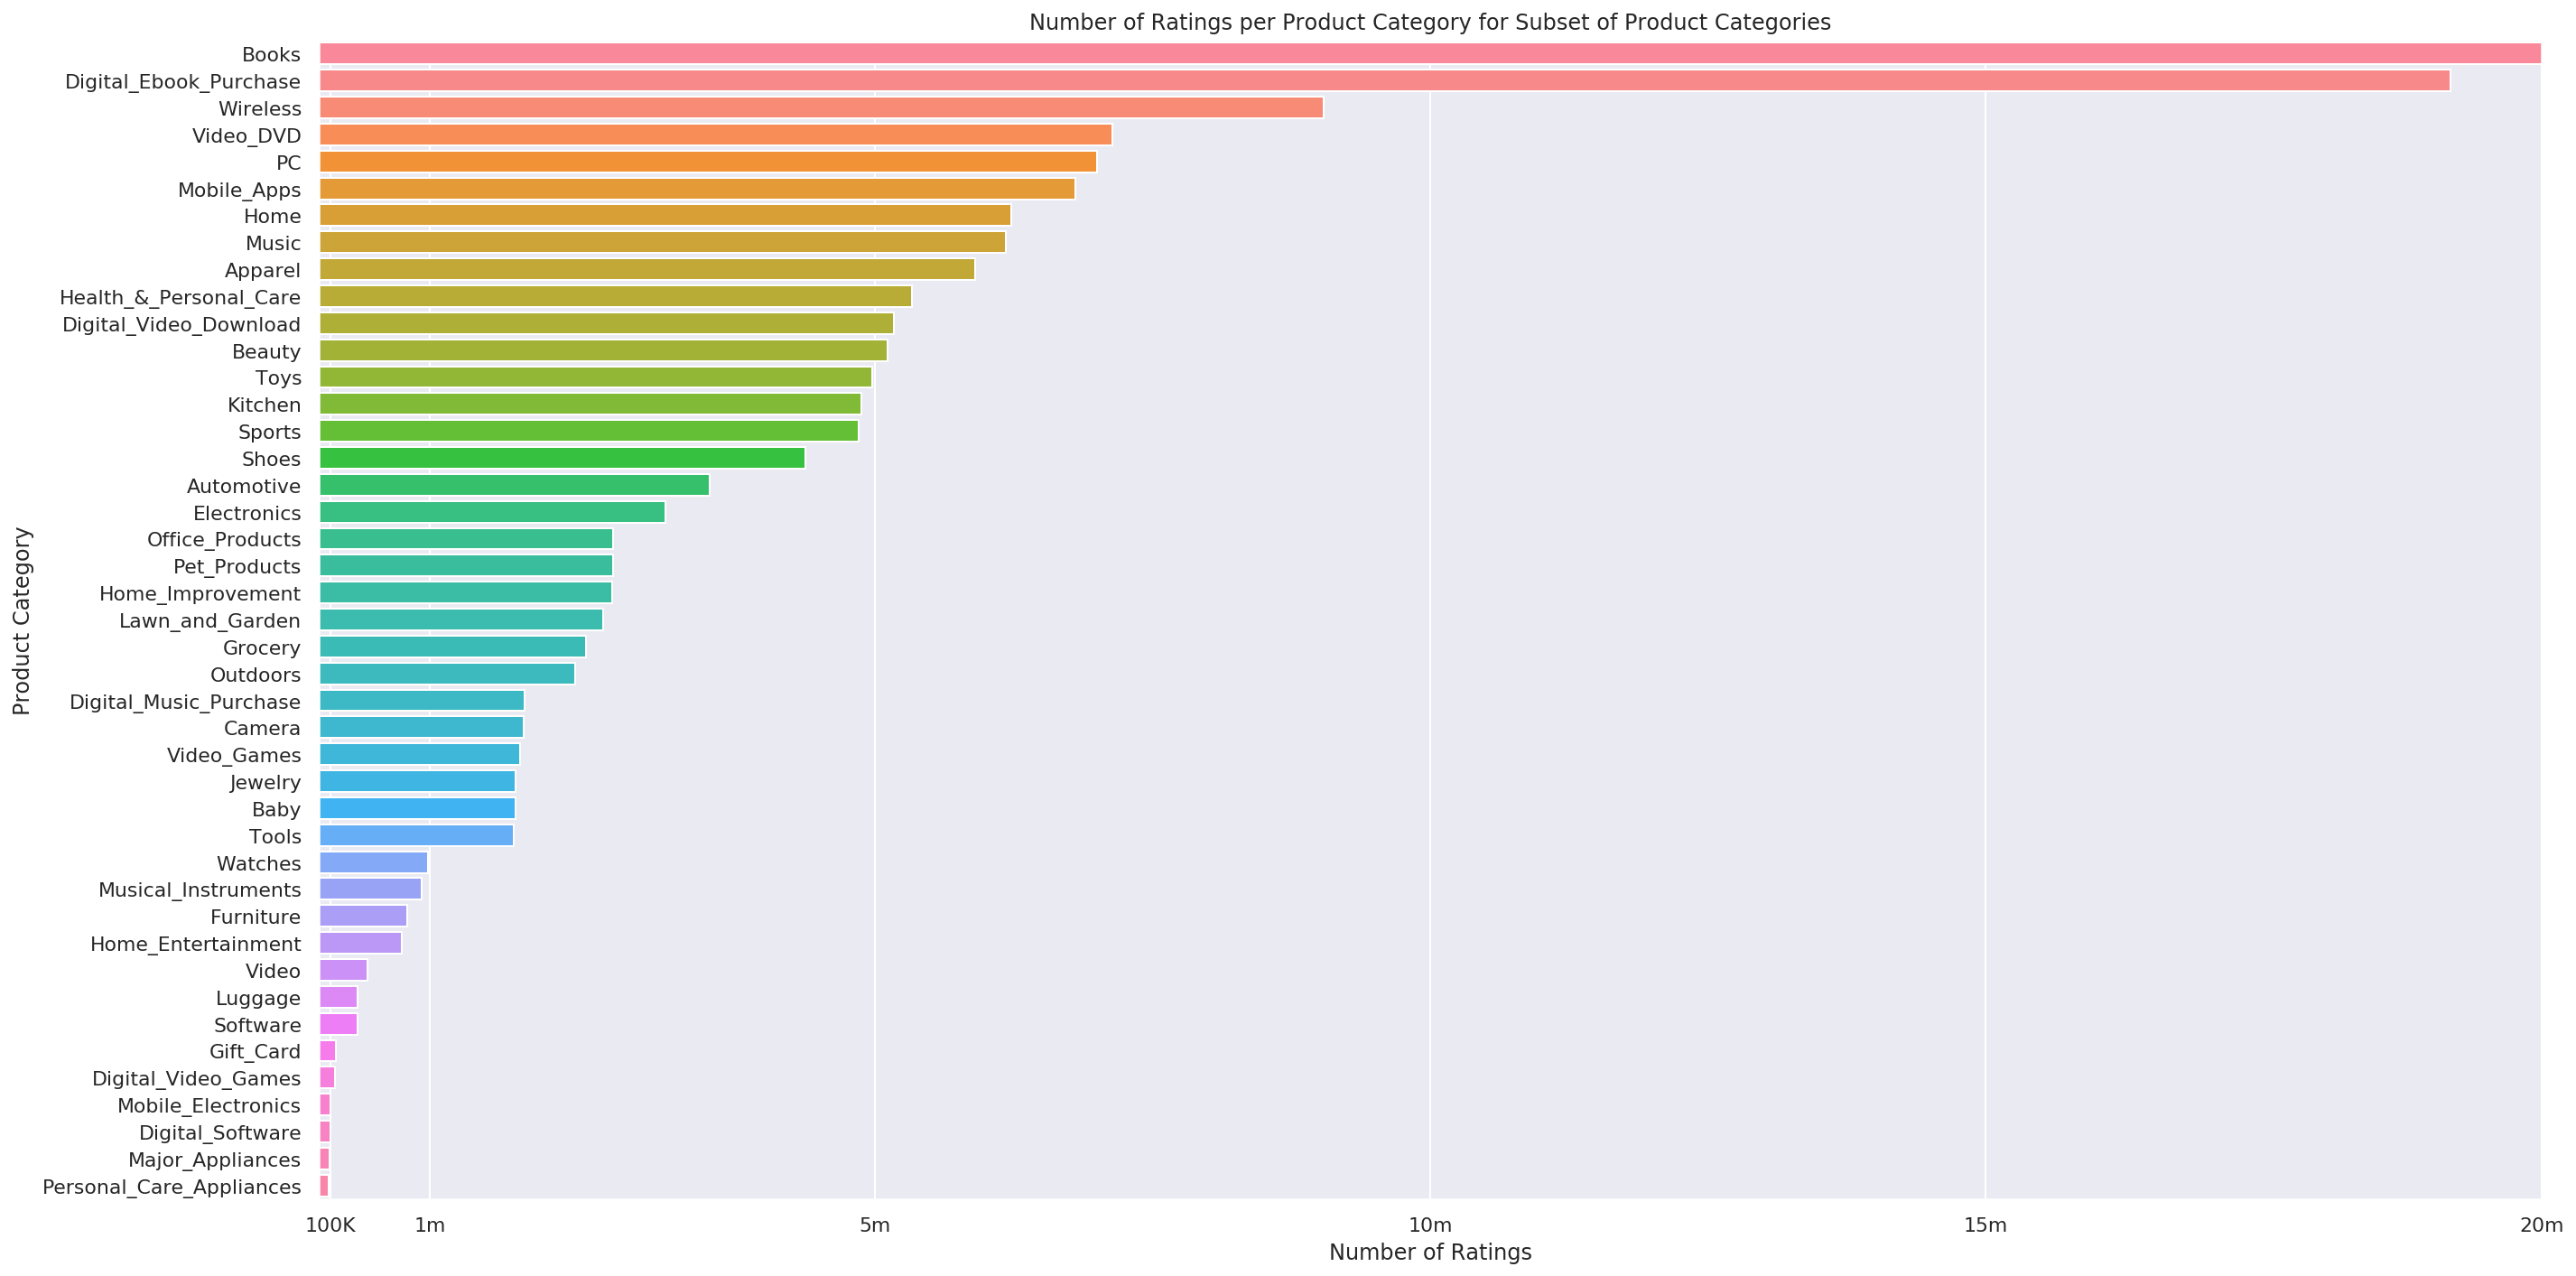

In [43]:
# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (20.0, 10.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "150K", "200K"])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

# 3. When did each product category become available in the Amazon catalog based on the date of the first review?

In [44]:
# SQL statement
statement = """
    SELECT product_category, MIN(year) AS first_review_year
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category
    ORDER BY first_review_year 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df.head()


    SELECT product_category, MIN(year) AS first_review_year
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category
    ORDER BY first_review_year 



,product_category,first_review_year
0,Gift_Card,2004
1,Digital_Video_Games,2006
2,Digital_Software,2008


In [45]:
def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df["first_review_year"].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values

In [46]:
X, Y = get_x_y(df)

## Visualization for a Subset of Product Categories

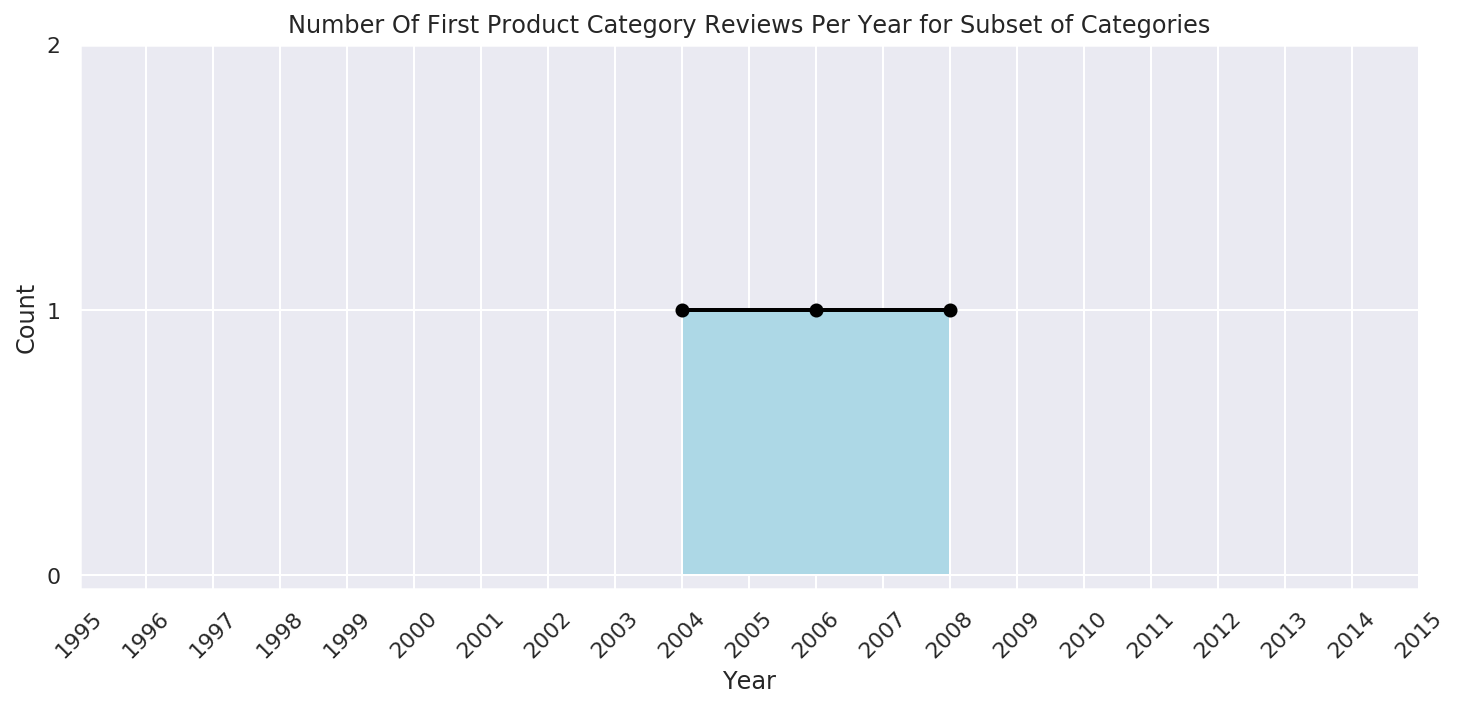

In [47]:
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.set_title("Number Of First Product Category Reviews Per Year for Subset of Categories")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

ax.plot(X, Y, color="black", linewidth=2, marker="o")
ax.fill_between(X, [0] * len(X), Y, facecolor="lightblue")

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y) + 2, 1))

plt.xticks(rotation=45)

# fig.savefig('first_reviews_per_year.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-04.png"  width="80%" align="left">

# 4. What is the breakdown of ratings (1-5) per product category?  


In [48]:
# SQL statement
statement = """
    SELECT product_category, star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY  product_category, star_rating
    ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT product_category, star_rating, COUNT(*) AS count_reviews
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY  product_category, star_rating
    ORDER BY  product_category ASC, star_rating DESC, count_reviews



,product_category,star_rating,count_reviews
0,Digital_Software,5,46410
1,Digital_Software,4,16693
2,Digital_Software,3,8308
3,Digital_Software,2,6890
4,Digital_Software,1,23783
5,Digital_Video_Games,5,80677
6,Digital_Video_Games,4,20406
7,Digital_Video_Games,3,11629
8,Digital_Video_Games,2,7749
9,Digital_Video_Games,1,24970


## Prepare for Stacked Percentage Horizontal Bar Plot Showing Proportion of Star Ratings per Product Category

In [49]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby("product_category")
grouped_star = df.groupby("star_rating")

In [50]:
# Create sum of ratings per star rating
df_sum = df.groupby(["star_rating"]).sum()
df_sum

,count_reviews
star_rating,
1,53546
2,16208
3,23093
4,46958
5,256796


In [51]:
# Calculate total number of star ratings
total = df_sum["count_reviews"].sum()
print(total)

396601


In [52]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i = 0

for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings["star_rating"]:
        count_reviews_per_star.append(ratings.at[i, "count_reviews"])
        i = i + 1
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)

{'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970], 'Gift_Card': [129709, 9859, 3156, 1569, 4793]}


In [53]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

dict_keys(['Digital_Software', 'Digital_Video_Games', 'Gift_Card'])


In [54]:
# Check if star rating distributions are set correctly
print(distribution.items())

dict_items([('Digital_Software', [46410, 16693, 8308, 6890, 23783]), ('Digital_Video_Games', [80677, 20406, 11629, 7749, 24970]), ('Gift_Card', [129709, 9859, 3156, 1569, 4793])])


In [55]:
# Sort distribution by average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:, 0]
for index, value in average_star_ratings.iloc[:, 0].items():
    sorted_distribution[value] = distribution[value]

In [58]:
df_sorted_distribution_pct = pd.DataFrame(sorted_distribution).transpose().apply(
    lambda num_ratings: num_ratings/sum(num_ratings)*100, axis=1
)
df_sorted_distribution_pct.columns=['5', '4', '3', '2', '1']
df_sorted_distribution_pct

,5,4,3,2,1
Gift_Card,87.002804,6.612962,2.116899,1.052413,3.214923
Digital_Video_Games,55.474417,14.031396,7.996232,5.328300,17.169654
Digital_Software,45.462560,16.352220,8.138396,6.749344,23.297481


## Visualization for a Subset of Product Categories

<Figure size 720x360 with 0 Axes>

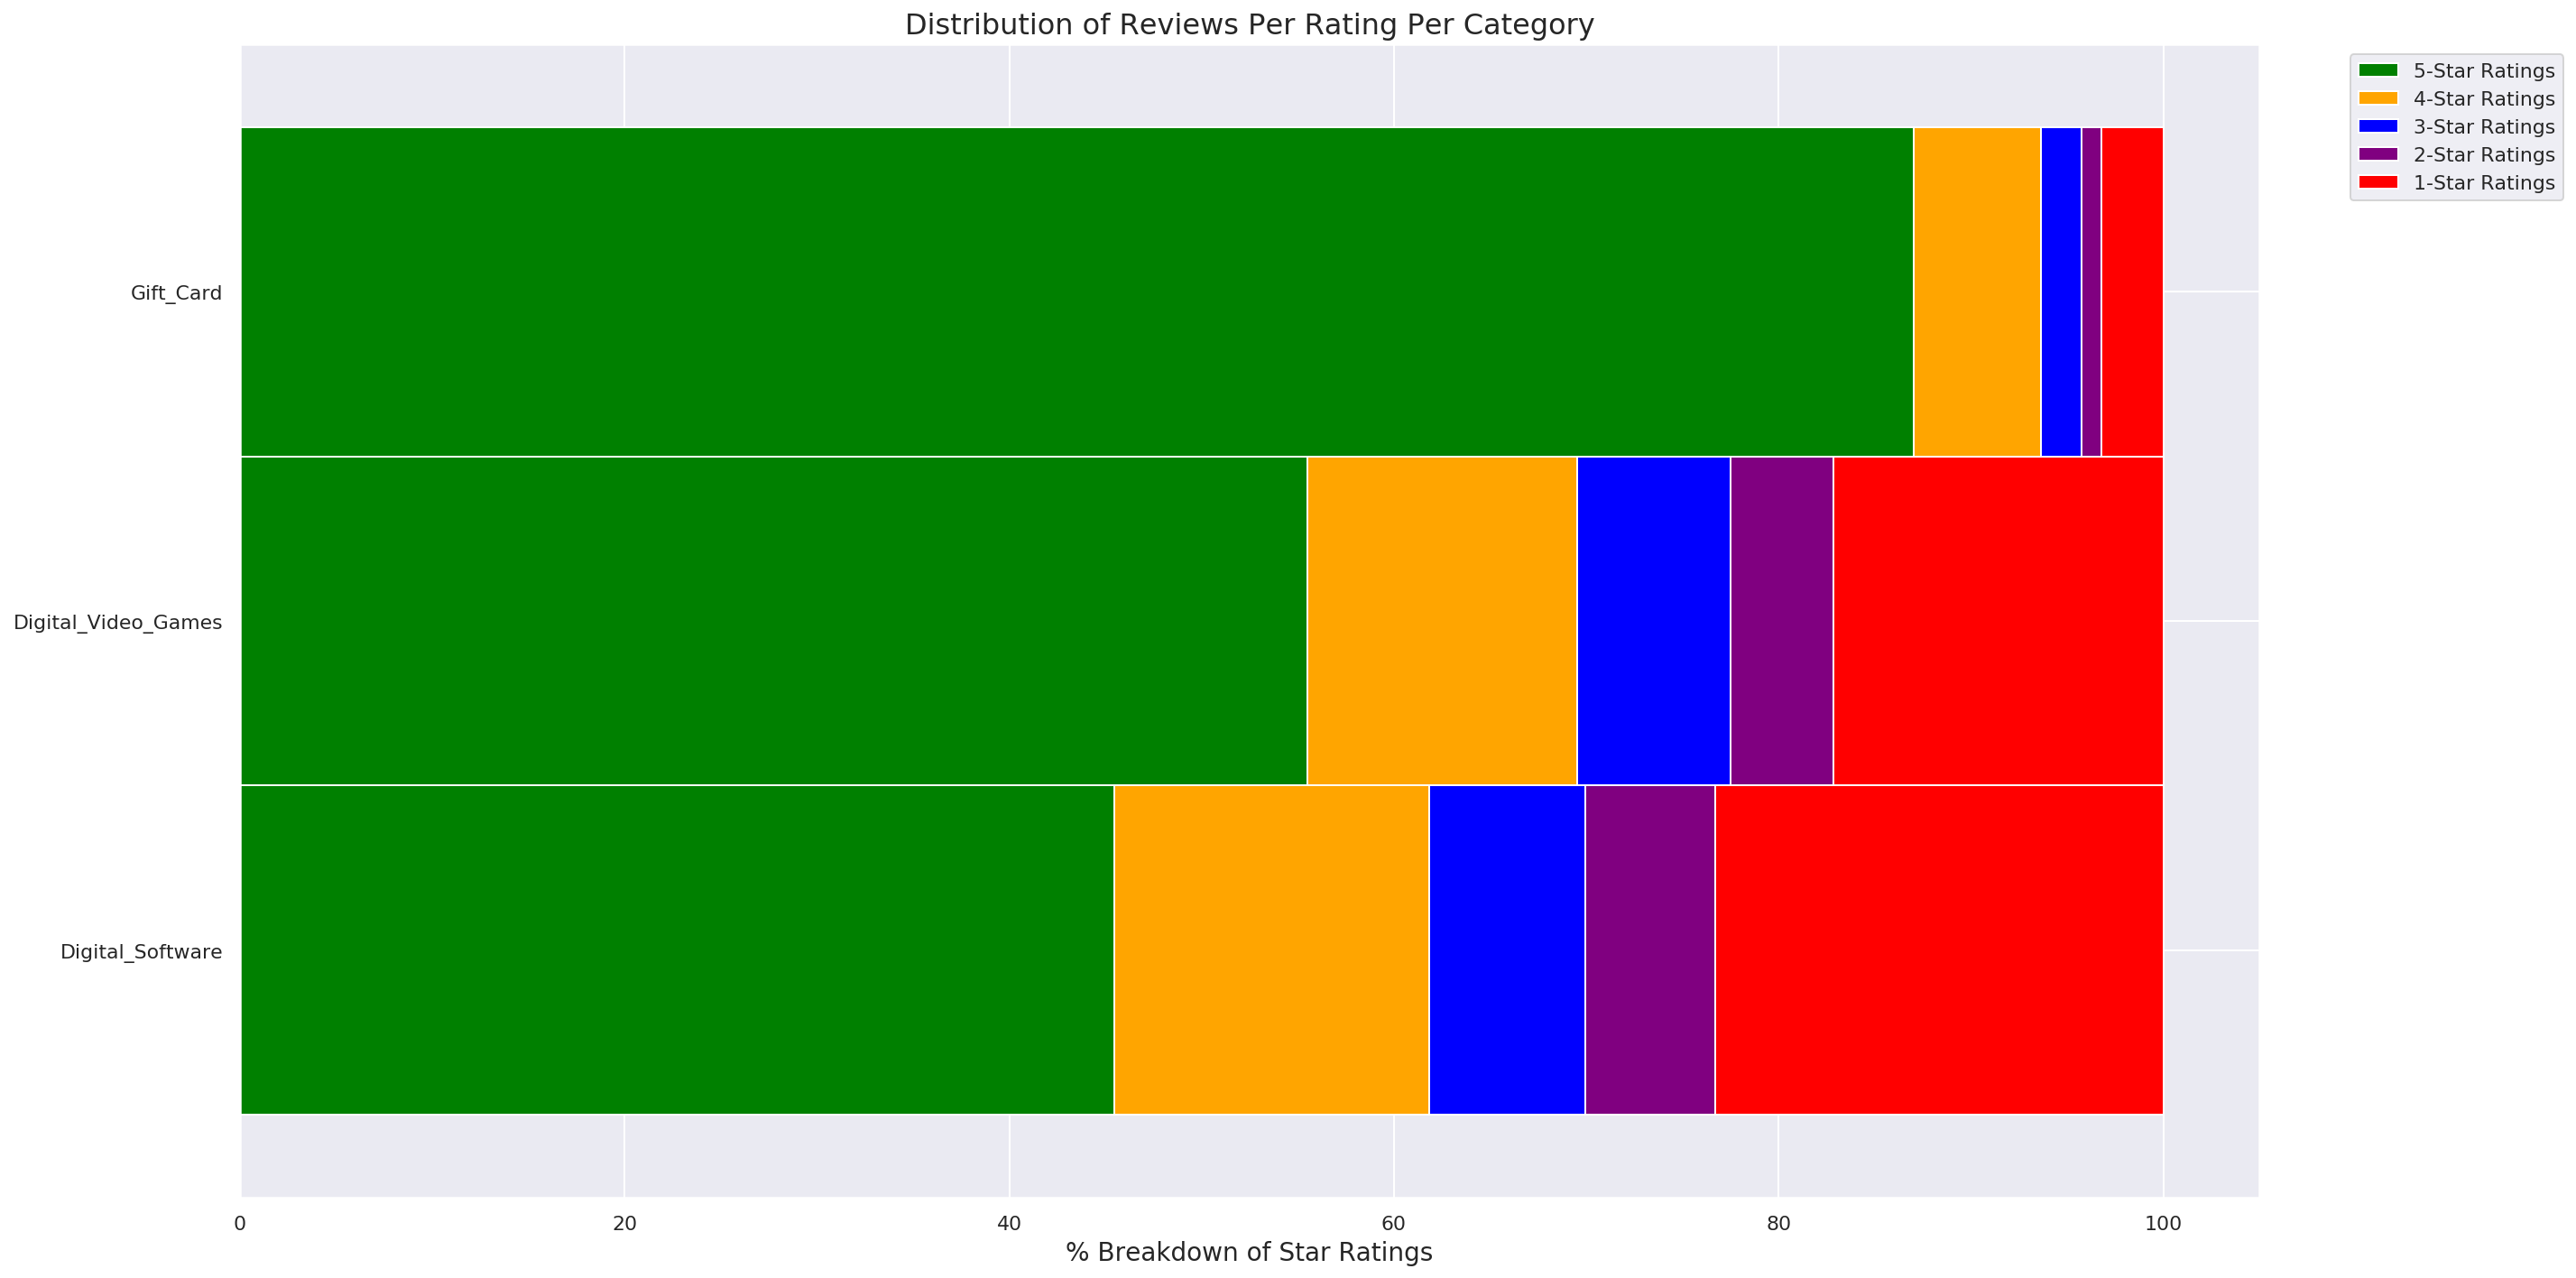

In [59]:
categories = df_sorted_distribution_pct.index

# Plot bars
if len(categories) > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

df_sorted_distribution_pct.plot(kind="barh", 
                                stacked=True, 
                                edgecolor='white',
                                width=1.0,
                                color=['green', 
                                       'orange', 
                                       'blue', 
                                       'purple', 
                                       'red'])

plt.title("Distribution of Reviews Per Rating Per Category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['5-Star Ratings', 
                   '4-Star Ratings', 
                   '3-Star Ratings', 
                   '2-Star Ratings', 
                   '1-Star Ratings'])

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c5-04.png"  width="70%" align="left">

# 5. How Many Reviews per Star Rating? (5, 4, 3, 2, 1) 

In [60]:
# SQL statement
statement = """
    SELECT star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY star_rating
    ORDER BY star_rating DESC, count_reviews 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT star_rating, COUNT(*) AS count_reviews
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY star_rating
    ORDER BY star_rating DESC, count_reviews 



,star_rating,count_reviews
0,5,256796
1,4,46958
2,3,23093
3,2,16208
4,1,53546


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_count_all.png"  width="25%" align="left">

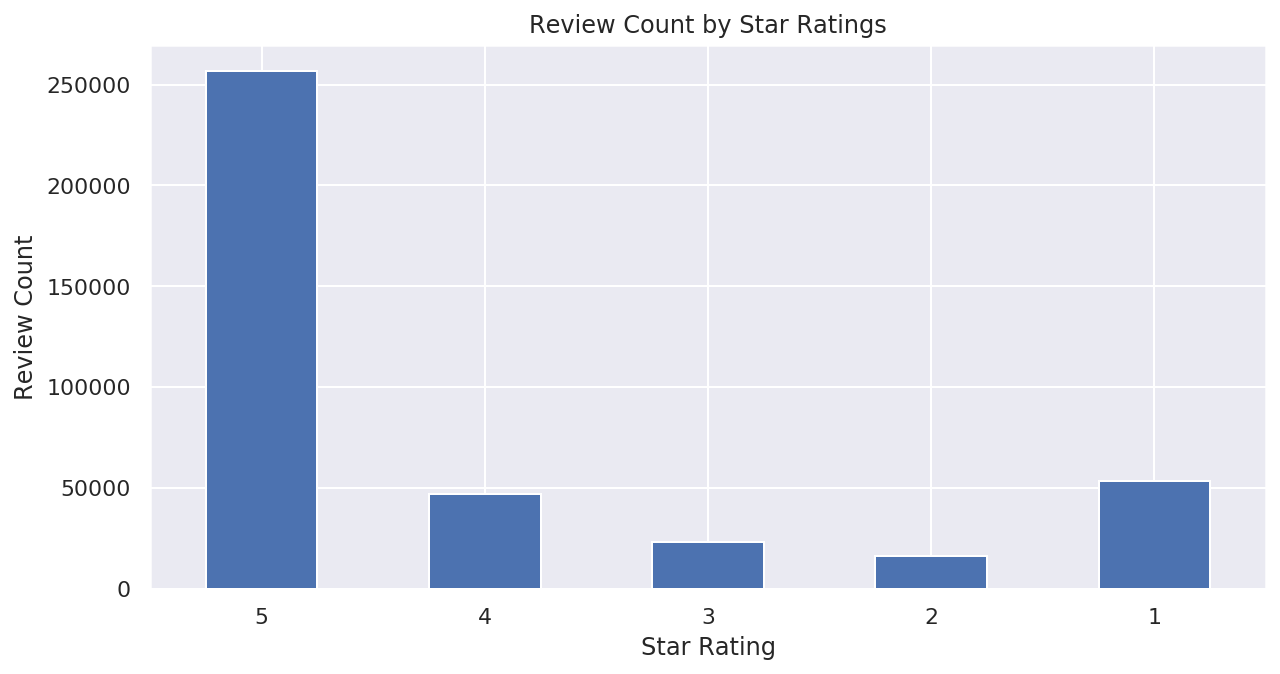

In [61]:
chart = df.plot.bar(
    x="star_rating", y="count_reviews", rot="0", figsize=(10, 5), title="Review Count by Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Review Count")

plt.show(chart)

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:


<img src="img/star_rating_count_all_bar_chart.png"  width="70%" align="left">

# 6. How Did Star Ratings Change Over Time?
Is there a drop-off point for certain product categories throughout the year?

## Average Star Rating Across All Product Categories

In [62]:
# SQL statement
statement = """
    SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY year
    ORDER BY year
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df


    SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
    FROM default.amazon_reviews_parquet
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY year
    ORDER BY year



,year,avg_rating
0,2004,4.5000
1,2005,3.2759
2,2006,3.3750
3,2007,3.9500
4,2008,2.8966
5,2009,3.7288
6,2010,3.7614
7,2011,3.9808
8,2012,4.0955
9,2013,4.0080


In [63]:
df["year"] = pd.to_datetime(df["year"], format="%Y").dt.year

## Visualization for a Subset of Product Categories

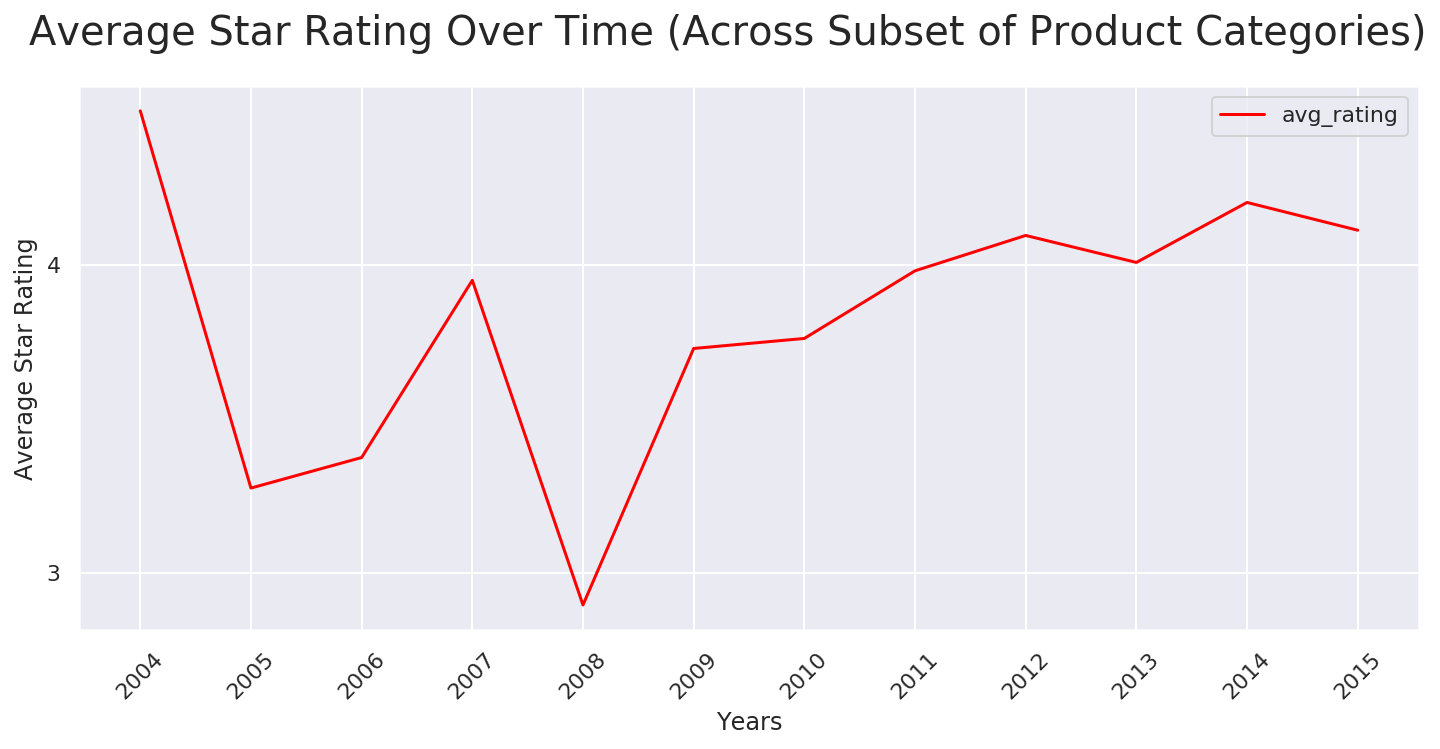

In [64]:
fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time (Across Subset of Product Categories)")

ax = plt.gca()
# ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

df.plot(kind="line", x="year", y="avg_rating", color="red", ax=ax)

# plt.xticks(range(1995, 2016, 1))
# plt.yticks(range(0,6,1))
plt.xlabel("Years")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-06.png"  width="70%" align="left">

## Average Star Rating Per Product Categories Across Time

In [ ]:
# SQL statement
statement = """
    SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY product_category, year
    ORDER BY year 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df

## Visualization

In [ ]:
def plot_categories(df):
    df_categories = df["product_category"].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df["product_category"] == category]
        df_plot.plot(
            kind="line",
            x="year",
            y="avg_rating_category",
            c=np.random.rand(
                3,
            ),
            ax=ax,
            label=category,
        )

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time Across Subset Of Categories")

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

plot_categories(df)

plt.xlabel("Year")
plt.ylabel("Average Star Rating")
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('average_rating_category_all_data.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories, you would see the following visualization:

<img src="img/average_rating_category_all_data.png"  width="70%" align="left">

# 7. Which Star Ratings (1-5) are Most Helpful?

In [ ]:
# SQL statement
statement = """
    SELECT star_rating, AVG(helpful_votes) AS avg_helpful_votes
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    GROUP BY  star_rating
    ORDER BY  star_rating ASC
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_helpful_all.png"  width="25%" align="left">

## Visualization for a Subset of Product Categories

In [ ]:
chart = df.plot.bar(
    x="star_rating", y="avg_helpful_votes", rot="0", figsize=(10, 5), title="Helpfulness Of Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Average Helpful Votes")

plt.show(chart)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-08.png"  width="60%" align="left">

# 8. Which Products have Most Helpful Reviews?  How Long are the Most Helpful Reviews?

In [ ]:
# SQL statement
statement = """
    SELECT product_title, helpful_votes, star_rating,
           LENGTH(review_body) AS review_body_length,
           SUBSTR(review_body, 1, 100) AS review_body_substr
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    ORDER BY helpful_votes DESC LIMIT 10 
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/most_helpful_all.png"  width="90%" align="left">

# 9. What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews?

In [ ]:
# SQL statement
statement = """
    SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
    FROM (
      SELECT count(*) AS positive_review_count
      FROM {}.{}
      WHERE star_rating >= 4 and product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')

    ), (
      SELECT count(*) AS negative_review_count
      FROM {}.{}
      WHERE star_rating < 4 and product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
    )
""".format(
    database_name, table_name, database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df

## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/ratio_all.png"  width="25%" align="left">

# 10. Which Customers are Abusing the Review System by Repeatedly Reviewing the Same Product?  What Was Their Average Star Rating for Each Product?

In [ ]:
# SQL statement
statement = """
    SELECT customer_id, product_category, product_title, 
    ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
    FROM {}.{} 
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')    
    GROUP BY customer_id, product_category, product_title 
    HAVING COUNT(*) > 1 
    ORDER BY review_count DESC
    LIMIT 5
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df

## Result for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:
  
<img src="img/athena-abuse-all.png"  width="60%" align="left">

# 11. What is the distribution of review lengths (number of words)?

In [ ]:
statement = """
    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM {}.{}
    WHERE product_category in ('Digital_Software', 'Gift_Card', 'Digital_Video_Games')
""".format(
    database_name, table_name
)

print(statement)

df = pd.read_sql(statement, conn)
df

In [ ]:
summary = df["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

In [ ]:
df["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["80%"], c="red"
)

# Release Resources

In [65]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>